In [1]:
# Data Processing and model code
# import necessary packages

import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import time
import datetime
from pathlib import Path
import glob

tf.random.set_seed(1234)

# path="wiki_crop/00"
# load dataset
with open("labaled_data.json", "r") as outfile:
            data = json.load(outfile)

with open("labaled_data.json", "r") as outfile:
    our_data = json.load(outfile)

data.update(our_data)
classes = set()
for i in data:
    classes.add(data.get(i)[1])
classes = list(classes)

<IPython.core.display.Javascript object>


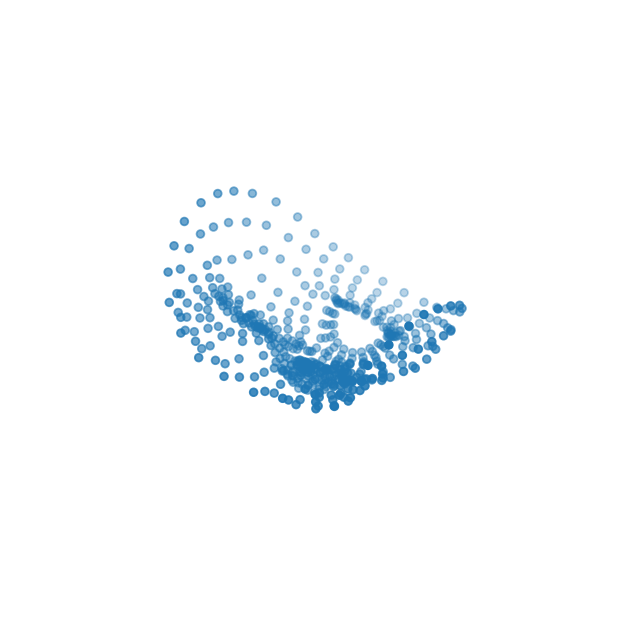

In [2]:
%matplotlib notebook
points = np.array(data.get(list(data.keys())[2])[0])
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [3]:
def parse_split_dataset(data, classes, num_points=478):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = classes

    for i in enumerate(list(data.keys())):
        if i[0] < int(len(list(data.keys()))*0.7):
            train_points.append(data.get(i[1])[0])
            train_labels.append(classes.index(data.get(i[1])[1]))
        else:
            test_points.append(data.get(i[1])[0])
            test_labels.append(classes.index(data.get(i[1])[1]))
        
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )


In [4]:
NUM_POINTS = 478
NUM_CLASSES = 2
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_split_dataset(data, classes, NUM_POINTS)

In [5]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


In [6]:
train_dataset

<BatchDataset shapes: ((None, 478, 3), (None,)), types: (tf.float64, tf.int32)>

In [7]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [8]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        super().__init__()
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    def get_config(self):
        config = super().get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

In [9]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


In [10]:
#Point net model
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_name = "./Pointnet"
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
model.summary()


Model: "./Pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 478, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 478, 32)      128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 478, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 478, 32)      0           batch_normalization[0][0]        
_________________________________________________________________________________________

In [14]:
try:
    model.load_weights(model_name)
except:
    print("no model data")
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

checkpoint_filepath = "./checkpoint_"+model_name

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_checkpoint_callback,tensorboard_callback])

# model.load_weights(checkpoint_filepath)
model.save_weights(model_name)

Epoch 1/100
14/14 [==============================] - 6s 125ms/step - loss: 1.3805 - sparse_categorical_accuracy: 0.8853 - val_loss: 4.5365 - val_sparse_categorical_accuracy: 0.6129
Epoch 2/100
14/14 [==============================] - 1s 74ms/step - loss: 1.3897 - sparse_categorical_accuracy: 0.8845 - val_loss: 2.7835 - val_sparse_categorical_accuracy: 0.5645
Epoch 3/100
14/14 [==============================] - 1s 52ms/step - loss: 1.3326 - sparse_categorical_accuracy: 0.9035 - val_loss: 4.2457 - val_sparse_categorical_accuracy: 0.6022
Epoch 4/100
14/14 [==============================] - 1s 49ms/step - loss: 1.3556 - sparse_categorical_accuracy: 0.8942 - val_loss: 5.5759 - val_sparse_categorical_accuracy: 0.5860
Epoch 5/100
14/14 [==============================] - 1s 51ms/step - loss: 1.3443 - sparse_categorical_accuracy: 0.8781 - val_loss: 3.5133 - val_sparse_categorical_accuracy: 0.5806
Epoch 6/100
14/14 [==============================] - 1s 52ms/step - loss: 1.3331 - sparse_categoric

14/14 [==============================] - 1s 49ms/step - loss: 1.2902 - sparse_categorical_accuracy: 0.9335 - val_loss: 3.0447 - val_sparse_categorical_accuracy: 0.5806
Epoch 46/100
14/14 [==============================] - 1s 52ms/step - loss: 1.2307 - sparse_categorical_accuracy: 0.9483 - val_loss: 11.6014 - val_sparse_categorical_accuracy: 0.6183
Epoch 47/100
14/14 [==============================] - 1s 46ms/step - loss: 1.2435 - sparse_categorical_accuracy: 0.9339 - val_loss: 9.5264 - val_sparse_categorical_accuracy: 0.6398
Epoch 48/100
14/14 [==============================] - 1s 53ms/step - loss: 1.2772 - sparse_categorical_accuracy: 0.9341 - val_loss: 2.6138 - val_sparse_categorical_accuracy: 0.5645
Epoch 49/100
14/14 [==============================] - 1s 52ms/step - loss: 1.2785 - sparse_categorical_accuracy: 0.9270 - val_loss: 3.1450 - val_sparse_categorical_accuracy: 0.6237
Epoch 50/100
14/14 [==============================] - 1s 46ms/step - loss: 1.2046 - sparse_categorical_accu

14/14 [==============================] - 1s 41ms/step - loss: 1.2241 - sparse_categorical_accuracy: 0.9459 - val_loss: 2.4775 - val_sparse_categorical_accuracy: 0.6559
Epoch 91/100
14/14 [==============================] - 1s 42ms/step - loss: 1.1863 - sparse_categorical_accuracy: 0.9684 - val_loss: 2.6480 - val_sparse_categorical_accuracy: 0.6344
Epoch 92/100
14/14 [==============================] - 1s 44ms/step - loss: 1.1767 - sparse_categorical_accuracy: 0.9720 - val_loss: 2.6440 - val_sparse_categorical_accuracy: 0.6505
Epoch 93/100
14/14 [==============================] - 1s 41ms/step - loss: 1.1462 - sparse_categorical_accuracy: 0.9714 - val_loss: 3.4999 - val_sparse_categorical_accuracy: 0.5968
Epoch 94/100
14/14 [==============================] - 1s 46ms/step - loss: 1.1477 - sparse_categorical_accuracy: 0.9690 - val_loss: 3.1440 - val_sparse_categorical_accuracy: 0.6129
Epoch 95/100
14/14 [==============================] - 1s 45ms/step - loss: 1.3262 - sparse_categorical_accur

<IPython.core.display.Javascript object>


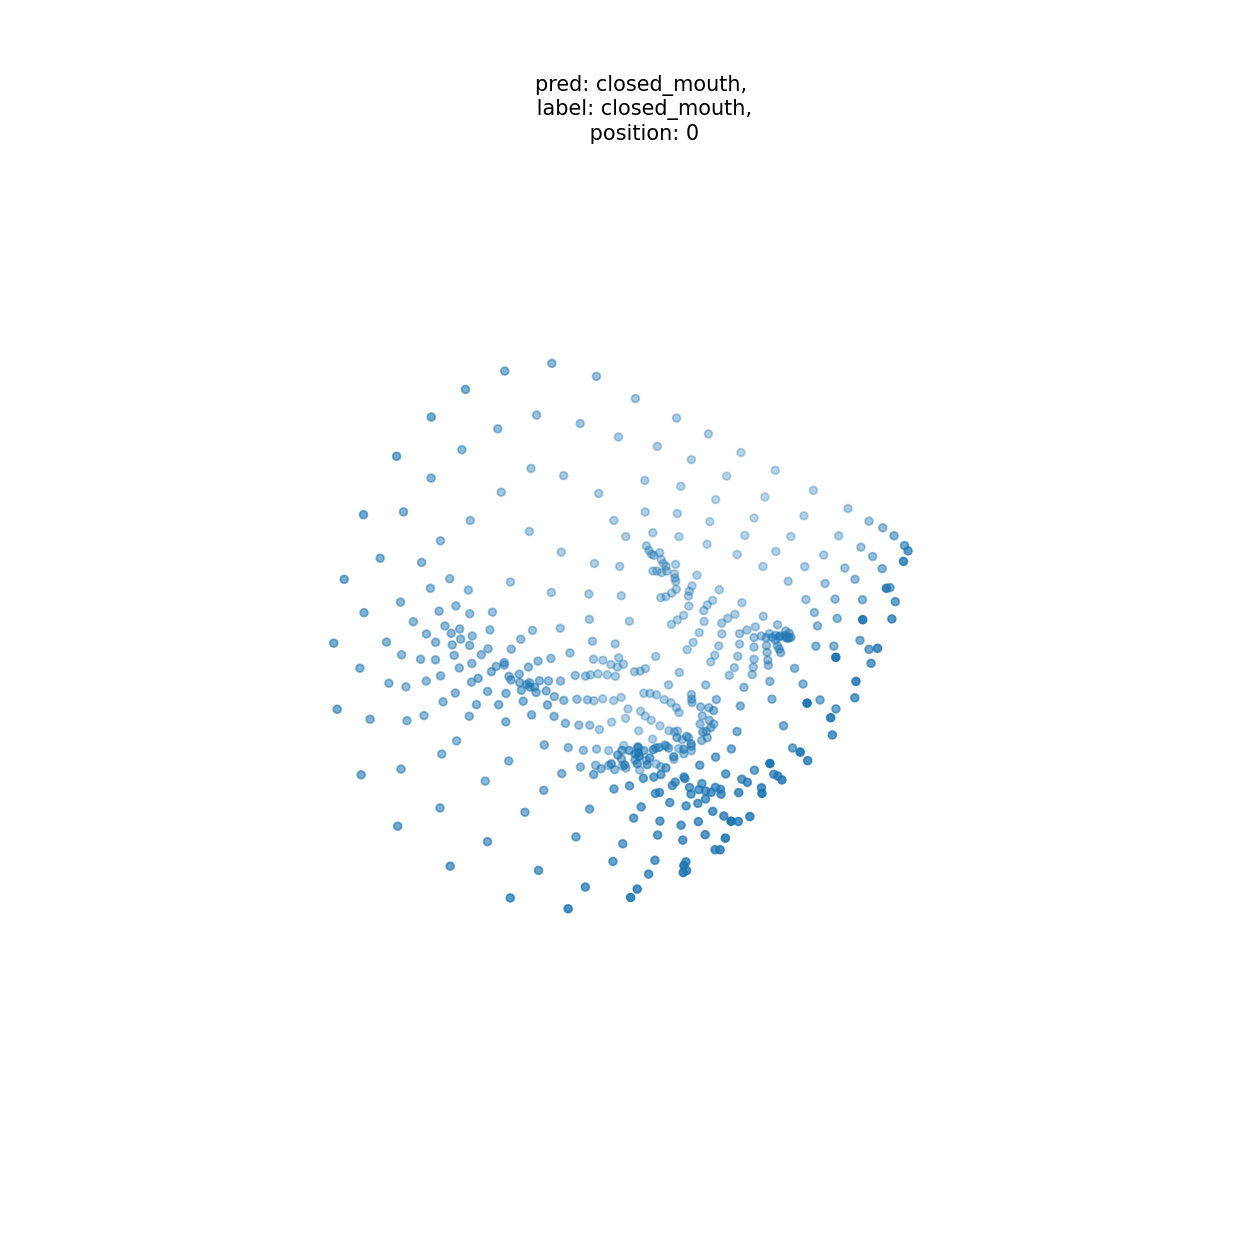

In [12]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:1, ...]
labels = labels[:1, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(10, 10))
for i in range(1):
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:},\n label: {:},\n position: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]], i
        )
    )
    ax.set_axis_off()
    plt.show()


In [13]:
display(len(train_points))

431